<center> <h1>TAILab Solution for Urinary Stone Challenge</h1> </center>
<h4 style='text-align: right;'> Made by TAIL </h4>

----
<h3>Introduction</h3>
This jupyter notebook provide full code which we used to train deep learning model in MOAI MCRC Deep Learning Challenge for urinary stone challenge. During the challenge we have to segment urinary stones from the given CT images.
<h3>Tools</h3>
<ul>
 <li>jupyter notebook</li>
 <li>pytorch(1.1.0)</li>
 <li>imgaug (0.4.0)</li>
 <li>cv2 (4.1)</li>
 <li>SimpleITK(1.2.0)</li>
</ul>

<h3>Data</h3>
Computed tomography(CT) Slices of urinary stone are provided in the follow configuration.

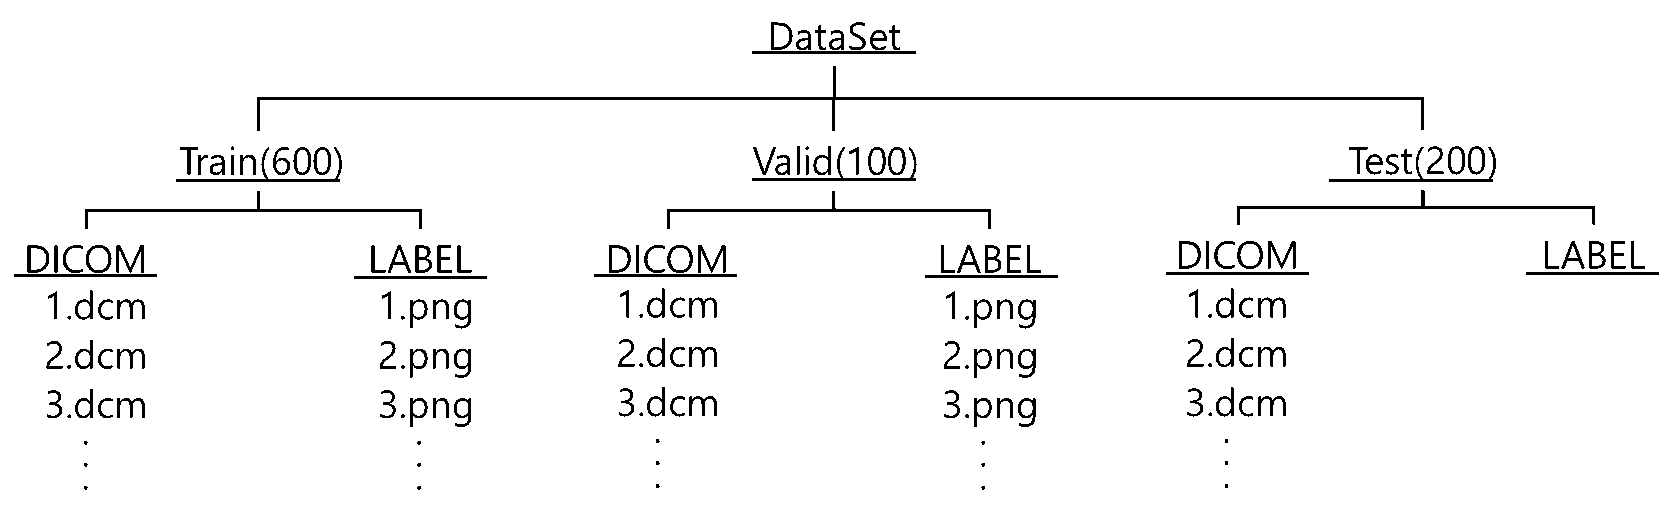

<ul>
<li>Train: 600 slices</li>
<li>Valid: 100 slices</li>
<li>Test: 200 slices</li>
</ul>

Datasets are divided into Train, Validation and Test. As shown in the figure above, CT files are in DICOM format and LABEL file in PNG. DICOM filename and PNG filename are configured to match. Each DICOM file is an anonymous CT file, and LABEL file is expressed only the masked part in red.

-Example


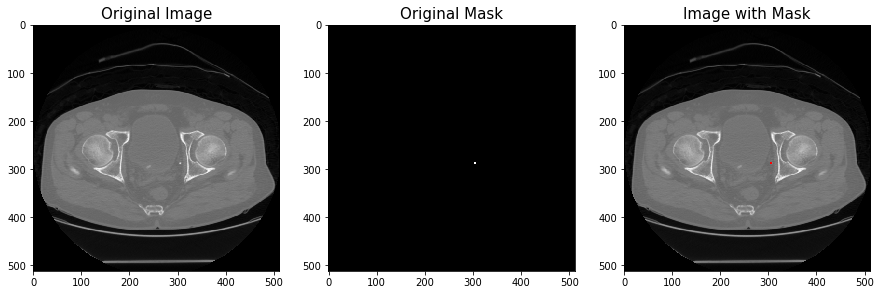

<h3>How we trained our model</h3>
We train Modified-Unet from the scratch for 150 epochs with a batch size of 16. We use Adam optimizer and Dice loss as the loss function. Learning rate is scheduled by Epoch-based decay and the initial learning rate set to 2e-5. Mean Intersection over Union(mIoU) is used for evaluation.


----


<h2>Table of contents</h2>

> <h4>Basic Settings</h4>

- [Hyper-parameters](#Hyper-parameters)
- [Import Libraries](#Libraries)

> <h4>Data explore</h4>

- [plot functions](#plot)
- [Visualize sample data](#visualized)

> <h4>Model</h4>

- [Network](#Network)
- [Data Pre-processing](#Pre-processing)
- [Dataset and Dataloader](#Dataloader)
- [Optimizer and Loss](#Optimizer)
- [ETC](#ETC)
- [Evaluation Metrics](#EvaluationMetrics)
- [Learning rate](#LR)
- [Core functions](#corefunctions)

> <h4>Main code</h4>

 - [Train](#train)
 - [Evaluation](#evaluation)
 - [Inference](#Inference)

# Basic Settings

## Hyper-parameters
<a id="Hyper-parameters"></a>

In [ ]:
# Directory
data_root = '../input/urinary-stone-challenge/DataSet'
save_dir = './result'

# Input image
crop_size = 300
input_size = 224
w_min = -100.
w_max = 300.

# Data augmentation
rot_factor = 30. 
scale_factor = 0.15
flip = True
trans_factor = 0.1

# Network
base_n_filter = 32

# Optimizer
lr = 2e-5
lr_decay_epoch = '130,145'
lr_warmup_epoch = 0
no_bias_decay = True

# Hyper-parameter
batch_size = 16
start_epoch = 0
max_epoch = 150
conf_threshold = 0.9

# Loss function
loss = 'dice'

# Resume trained network
resume = ''

# Resource option
workers = 10
gpu_id = "0"

In [ ]:
import os

# Make output directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# GPU Setting
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id
ngpu = len(gpu_id.split(","))

## Import Libraries
<a id="Libraries"></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader,Dataset

import cv2
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import uniform
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt 

from glob import glob
import SimpleITK as sitk

import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True

In [ ]:
# Seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Data explore

## Plot functions
<a id="plot"></a>

In [ ]:
def overlay_mask_on_img(img, mask):
    overlay_img = (img - img.min()) / (img.max() - img.min())
    overlay_img = (overlay_img * 255).astype(np.uint8)
    overlay_img = np.repeat(overlay_img[...,None], 3, -1)
    overlay_img[mask != 0] = [255,0,0]
    
    return overlay_img

In [ ]:
def plot_images(ori,mask,overl)
  fig, axes = plt.subplots(1, 3, figsize=(15,7))

  axes[0].imshow(ori, 'gray')
  axes[0].set_title("Original Image", fontsize=15)

  axes[1].imshow(mask, 'gray')
  axes[1].set_title("Original Mask", fontsize=15)

  axes[2].imshow(overl)
  axes[2].set_title("Image with Mask", fontsize=15)

  plt.show()

## Visualize sample data
<a id="visualized"></a>

In [ ]:
# load sample data
sample_img_1  = '../DataSet/TRAIN/DCM/123.dcm'
sample_mask_1 = '../DataSet/TRAIN/Label/123.png'

sample_img_2  = '../DataSet/Valid/DCM/626.dcm'
sample_mask_2 = '../DataSet/Valid/Label/626.png'

# img2numpy
img_train = sitk.ReadImage(sample_img_1)
img_arr_train = sitk.GetArrayFromImage(img_train)[0]
mask_train = cv2.imread(sample_mask_1, 0)

img_valid = sitk.ReadImage(sample_img_2)
img_arr_valid = sitk.GetArrayFromImage(img_valid)[0]
mask_valid = cv2.imread(sample_mask_2, 0)

# overay images
overlay_img_train = overlay_mask_on_img(img_arr_train, mask_train)
overlay_img_valid = overlay_mask_on_img(img_arr_valid, mask_valid)

In [ ]:
plot_images(img_arr_train,mask_train,overlay_img_train)

In [ ]:
plot_images(img_arr_valid,mask_valid,overlay_img_valid)

# Model

## Network
<a id="Network"></a>

In [ ]:
class Modified2DUNet(nn.Module):
    '''
    Reference : https://github.com/pykao/Modified-3D-UNet-Pytorch
    Description : We changed original 3D version of Modified U-Net to 2D version.
    '''
    def __init__(self, in_channels, n_classes, base_n_filter = 8):
        super(Modified2DUNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        self.dropout3d = nn.Dropout3d(p=0.6)
        

        # Level 1 context pathway
        self.conv3d_c1_1 = nn.Conv2d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3d_c1_2 = nn.Conv2d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
        self.gnorm3d_c1 = nn.GroupNorm(self.base_n_filter//2, self.base_n_filter)

        # Level 2 context pathway
        self.conv3d_c2 = nn.Conv2d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
        self.gnorm3d_c2 = nn.GroupNorm(self.base_n_filter, self.base_n_filter*2)

        # Level 3 context pathway
        self.conv3d_c3 = nn.Conv2d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
        self.gnorm3d_c3 = nn.GroupNorm(self.base_n_filter, self.base_n_filter*4)

        # Level 4 context pathway
        self.conv3d_c4 = nn.Conv2d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
        self.gnorm3d_c4 = nn.GroupNorm(self.base_n_filter*2, self.base_n_filter*8)

        # Level 5 context pathway, level 0 localization pathway
        self.conv3d_c5 = nn.Conv2d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0_1 = self.norm_lrelu_upscale_conv_norm_lrelu_1(self.base_n_filter*16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0_2 = self.norm_lrelu_upscale_conv_norm_lrelu_2(self.base_n_filter*16, self.base_n_filter*8)

        self.conv3d_l0 = nn.Conv2d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
        self.gnorm3d_l0 = nn.GroupNorm(self.base_n_filter*2, self.base_n_filter*8)

        # Level 1 localization pathway
        self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
        self.conv3d_l1 = nn.Conv2d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1_1 = self.norm_lrelu_upscale_conv_norm_lrelu_1(self.base_n_filter*8)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1_2 = self.norm_lrelu_upscale_conv_norm_lrelu_2(self.base_n_filter*8, self.base_n_filter*4)

        # Level 2 localization pathway
        self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
        self.conv3d_l2 = nn.Conv2d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2_1 = self.norm_lrelu_upscale_conv_norm_lrelu_1(self.base_n_filter*4)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2_2 = self.norm_lrelu_upscale_conv_norm_lrelu_2(self.base_n_filter*4, self.base_n_filter*2)

        # Level 3 localization pathway
        self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
        self.conv3d_l3 = nn.Conv2d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3_1 = self.norm_lrelu_upscale_conv_norm_lrelu_1(self.base_n_filter*2)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3_2 = self.norm_lrelu_upscale_conv_norm_lrelu_2(self.base_n_filter*2, self.base_n_filter)

        # Level 4 localization pathway
        self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
        self.conv3d_l4 = nn.Conv2d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

        self.ds2_1x1_conv3d = nn.Conv2d(self.base_n_filter*8, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)
        self.ds3_1x1_conv3d = nn.Conv2d(self.base_n_filter*4, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

        
    def conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.Conv2d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(feat_out//2, feat_out),
            nn.LeakyReLU())

    def norm_lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.GroupNorm(feat_in//2, feat_in),
            nn.LeakyReLU(),
            nn.Conv2d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def norm_lrelu_upscale_conv_norm_lrelu_1(self, feat_in):
        return nn.Sequential(
            nn.GroupNorm(feat_in//2, feat_in),
            nn.LeakyReLU())

    def norm_lrelu_upscale_conv_norm_lrelu_2(self, feat_in, feat_out):
        return nn.Sequential(
            # should be feat_in*2 or feat_in
            nn.Conv2d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(feat_out//2, feat_out),
            nn.LeakyReLU())

    def forward(self, x):
        #  Level 1 context pathway
        out = self.conv3d_c1_1(x)
        residual_1 = out
        out = self.lrelu(out)
        out = self.conv3d_c1_2(out)
        out = self.dropout3d(out)
        out = self.lrelu_conv_c1(out)
        # Element Wise Summation
        out += residual_1
        context_1 = self.lrelu(out)
        out = self.gnorm3d_c1(out)
        out = self.lrelu(out)

        # Level 2 context pathway
        out = self.conv3d_c2(out)
        residual_2 = out
        out = self.norm_lrelu_conv_c2(out)
        out = self.norm_lrelu_conv_c2(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c2(out)
        out = self.norm_lrelu_conv_c2(out)
        out += residual_2
        out = self.gnorm3d_c2(out)
        out = self.lrelu(out)
        context_2 = out

        # Level 3 context pathway
        out = self.conv3d_c3(out)
        residual_3 = out
        out = self.norm_lrelu_conv_c3(out)
        out = self.norm_lrelu_conv_c3(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c3(out)
        out = self.norm_lrelu_conv_c3(out)
        out += residual_3
        out = self.gnorm3d_c3(out)
        out = self.lrelu(out)
        context_3 = out

        # Level 4 context pathway
        out = self.conv3d_c4(out)
        residual_4 = out
        out = self.norm_lrelu_conv_c4(out)
        out = self.norm_lrelu_conv_c4(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c4(out)
        out = self.norm_lrelu_conv_c4(out)
        out += residual_4
        out = self.gnorm3d_c4(out)
        out = self.lrelu(out)
        context_4 = out

        # Level 5
        out = self.conv3d_c5(out)
        residual_5 = out
        out = self.norm_lrelu_conv_c5(out)
        out = self.norm_lrelu_conv_c5(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c5(out)
        out = self.norm_lrelu_conv_c5(out)
        out += residual_5
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l0_1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l0_2(out)

        out = self.conv3d_l0(out)
        out = self.gnorm3d_l0(out)
        out = self.lrelu(out)

        # Level 1 localization pathway
        out = F.interpolate(out, size = context_4.size()[-2:])
        out = torch.cat([out, context_4], dim=1)
        out = self.conv_norm_lrelu_l1(out)
        out = self.conv3d_l1(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l1_1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l1_2(out)


        # Level 2 localization pathway
        out = F.interpolate(out, size = context_3.size()[-2:])
        out = torch.cat([out, context_3], dim=1)
        out = self.conv_norm_lrelu_l2(out)
        ds2 = out
        out = self.conv3d_l2(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l2_1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l2_2(out)

        # Level 3 localization pathway
        out = F.interpolate(out, size = context_2.size()[-2:])
        out = torch.cat([out, context_2], dim=1)
        out = self.conv_norm_lrelu_l3(out)
        ds3 = out
        out = self.conv3d_l3(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l3_1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l3_2(out)

        # Level 4 localization pathway
        out = F.interpolate(out, size = context_1.size()[-2:])
        out = torch.cat([out, context_1], dim=1)
        out = self.conv_norm_lrelu_l4(out)
        out_pred = self.conv3d_l4(out)

        ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
        ds1_ds2_sum_upscale = F.interpolate(ds2_1x1_conv, scale_factor=2, mode='nearest')
        ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
        ds1_ds2_sum_upscale = F.interpolate(ds1_ds2_sum_upscale, size = ds3_1x1_conv.size()[-2:])
        ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
        ds1_ds2_sum_upscale_ds3_sum_upscale = F.interpolate(ds1_ds2_sum_upscale_ds3_sum, scale_factor=2, mode='nearest')

        out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
        
        return out

In [ ]:
net = Modified2DUNet(in_channels=1, n_classes=1, base_n_filter=base_n_filter)
net = net.cuda()

## Data Pre-processing
<a id="Pre-processing"></a>

In [ ]:
def image_windowing(img, w_min=0, w_max=300):
    img_w = img.copy()

    img_w[img_w < w_min] = w_min
    img_w[img_w > w_max] = w_max

    return img_w
    
def image_minmax(img):
    img_minmax = ((img - np.min(img)) / (np.max(img) - np.min(img))).copy()
    img_minmax = (img_minmax * 255).astype(np.uint8)
        
    return img_minmax

def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

def augment_imgs_and_masks(imgs, masks, rot_factor, scale_factor, trans_factor, flip):
    rot_factor = uniform(-rot_factor, rot_factor)
    scale_factor = uniform(1-scale_factor, 1+scale_factor)
    trans_factor = [int(imgs.shape[1]*uniform(-trans_factor, trans_factor)),
                    int(imgs.shape[2]*uniform(-trans_factor, trans_factor))]

    seq = iaa.Sequential([
            iaa.Affine(
                translate_px={"x": trans_factor[0], "y": trans_factor[1]},
                scale=(scale_factor, scale_factor),
                rotate=rot_factor
            )
        ])

    seq_det = seq.to_deterministic()

    imgs = seq_det.augment_images(imgs)
    masks = seq_det.augment_images(masks)

    if flip and uniform(0, 1) > 0.5:
        imgs = np.flip(imgs, 2).copy()
        masks = np.flip(masks, 2).copy()

    return imgs, masks

def center_crop(img, width):
    y, x = img.shape
    x_center = x/2.0
    y_center = y/2.0
    x_min = int(x_center - width/2.0)
    x_max = x_min + width
    y_min = int(y_center - width/2.0)
    y_max = y_min + width
    img_cropped = img[y_min:y_max, x_min: x_max]
    return img_cropped

## Dataset and Dataloader
<a id="Dataloader"></a>

In [ ]:
class UrinaryStoneDataset(Dataset):
    def __init__(self, is_Train=True, augmentation=True):
        super(UrinaryStoneDataset, self).__init__()
        global data_root, w_min, w_max, crop_size, input_size, rot_factor, scale_factor, trans_factor, flip

        self.dcm_list = sorted(glob(os.path.join(data_root, 'Train' if is_Train else 'Valid', 'DCM', '*.dcm')))
        self.len = len(self.dcm_list)
        self.augmentation = augmentation
        self.is_Train = is_Train
        
    def __getitem__(self, index):
        # Load Image and Mask
        dcm_path = self.dcm_list[index]
        filename = os.path.basename(dcm_path).rstrip('.dcm')
        mask_path = dcm_path.replace('DCM', 'Label').replace('.dcm', '.png')

        img_sitk = sitk.ReadImage(dcm_path)
        img = sitk.GetArrayFromImage(img_sitk)[0]
        mask = cv2.imread(mask_path, 0)

        # HU Windowing
        img = image_windowing(img, w_min, w_max)

        # Center Crop and MINMAX to [0, 255] and Resize
        img = center_crop(img, crop_size)
        mask = center_crop(mask, crop_size)
        
        img = image_minmax(img)
        
        img = cv2.resize(img, (input_size, input_size))
        mask = cv2.resize(mask, (input_size, input_size))

        # MINMAX to [0, 1]
        img = img / 255.

        # Mask Binarization (0 or 1)
        mask = mask_binarization(mask)

        # Add channel axis
        img = img[None, ...].astype(np.float32)
        mask = mask[None, ...].astype(np.float32)
                
        # Augmentation
        if self.augmentation:
            img, mask = augment_imgs_and_masks(img, mask, rot_factor, scale_factor, trans_factor, flip)
        
        if self.is_Train:
            return img, mask
        else:
            return img, mask, filename
        
    def __len__(self):
        return self.len

In [ ]:
# Make Data Loader
trn_dataset = UrinaryStoneDataset(is_Train=True, augmentation=True)
val_dataset = UrinaryStoneDataset(is_Train=False, augmentation=False)

train_dataloader = DataLoader(trn_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers)

valid_dataloader = DataLoader(val_dataset,
                              batch_size=1,
                              shuffle=False,
                              num_workers=workers)

## Optimizer & Loss
<a id="Optimizer"></a>

In [ ]:
def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
criterion = DiceLoss(sigmoid_normalization=True)

In [ ]:
if no_bias_decay:
    weight_params = []
    bias_params = []
    
    for n, p in net.named_parameters():
        if 'bias' in n:
            bias_params.append(p)
        else:
            weight_params.append(p)
    parameters = [{'params' : bias_params, 'weight_decay' : 0},
                  {'params' : weight_params}]
else:
    parameters = net.parameters()

optimizer = optim.Adam(parameters, lr=lr)

## ETC
<a id="ETC"></a>

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Evaluation Metrics
<a id="EvaluationMetrics"></a>

In [ ]:
def get_iou(preds, labels):
    SMOOTH = 1e-6

    preds = preds.squeeze(1).int()
    labels = labels.squeeze(1).int()

    intersection = (preds & labels).float().sum((1, 2)) # zero if mask=0 or Prediction=0
    union = (preds | labels).float().sum((1, 2)) # zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    return iou

def avg_precision(iou_list, thresh1=0.5, thresh2=0.75):
    # IoU array
    iou_array = np.array(iou_list)
    
    # thresh 1
    pred_binary_th1 = np.where(iou_array > thresh1, 1, 0)
    
    # thresh 2
    pred_binary_th2 = np.where(iou_array > thresh2, 1, 0)
    
    prec_thresh1 = np.sum(pred_binary_th1) / len(pred_binary_th1)
    prec_thresh2 = np.sum(pred_binary_th2) / len(pred_binary_th1)
    
    iou_mean = np.mean(iou_array)
    
    return prec_thresh1, prec_thresh2, iou_mean

## Learning rate
<a id="LR"></a>

In [ ]:
def get_current_lr(optimizer):
    return optimizer.state_dict()['param_groups'][0]['lr']

def lr_update(epoch, optimizer):
    global lr_warmup_epoch, lr_decay_epoch
    
    prev_lr = get_current_lr(optimizer)
    
    if 0 <= epoch < lr_warmup_epoch:
        mul_rate = 10 ** (1/lr_warmup_epoch)

        for param_group in optimizer.param_groups:
            param_group['lr'] *= mul_rate

        current_lr = get_current_lr(optimizer)
        print("LR warm-up : %.7f to %.7f" % (prev_lr, current_lr))

    else:
        if isinstance(lr_decay_epoch, list):
            if (epoch+1) in lr_decay_epoch:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = (prev_lr * 0.1)
                    print("LR Decay : %.7f to %.7f" % (prev_lr, prev_lr * 0.1))

## Core functions
<a id="corefunctions"></a>

In [ ]:
def train(net, train_dataloader, optimizer, criterion, epoch, train_writer):
    global max_epoch, conf_threshold
    
    print("Start Training...")
    net.train()

    losses, total_iou = AverageMeter(), AverageMeter()

    for it, (img, mask) in enumerate(train_dataloader):
        # Optimizer
        optimizer.zero_grad()

        # Load Data
        img, mask = torch.Tensor(img).float(), torch.Tensor(mask).float()
        img, mask = img.cuda(non_blocking=True), mask.cuda(non_blocking=True)

        # Predict
        pred = net(img)

        # Loss Calculation
        loss = criterion(pred, mask)
        
        # Backward and step
        loss.backward()
        optimizer.step()
        
        # Convert to Binary
        pred = pred.sigmoid()
        pred_mask = mask_binarization(pred, conf_threshold)

        # Calculation IoU Score
        iou_score = get_iou(pred_mask, mask)
        total_iou.update(iou_score.mean().item(), img.size(0))

        # Stack Results
        losses.update(loss.item(), img.size(0))
        
        # Print Results
        print('Epoch[%3d/%3d] | Iter[%3d/%3d] | Loss %.4f | Iou %.4f'
            % (epoch+1, max_epoch, it+1, len(train_dataloader), losses.avg, total_iou.avg), end='\r')

    print(">>> Epoch[%3d/%3d] | Training Loss : %.4f | Iou %.4f\n "
        % (epoch+1, max_epoch, losses.avg, total_iou.avg))

    train_writer.add_scalar("train/loss", losses.avg, epoch+1)
    train_writer.add_scalar("train/IoU", total_iou.avg, epoch+1)

In [ ]:
def validate(valid_dataloader, net, criterion, epoch, best_iou, best_epoch,train_writer):
    global save_dir, max_epoch, ngpu, conf_threshold
    
    print("Start Evaluation...")
    net.eval()

    # Result containers
    losses, total_iou = AverageMeter(), AverageMeter()

    for it, (img, mask, _) in enumerate(valid_dataloader):
        # Load Data
        img, mask = torch.Tensor(img).float(), torch.Tensor(mask).float()
        img, mask = img.cuda(non_blocking=True), mask.cuda(non_blocking=True)

        # Predict
        pred = net(img)

        # Loss Calculation
        loss = criterion(pred, mask)

        # Convert to Binary
        pred = pred.sigmoid()
        pred_mask = mask_binarization(pred, conf_threshold)

        # Calculation IoU Score
        iou_score = get_iou(pred_mask, mask)
        total_iou.update(iou_score.mean().item(), img.size(0))

        # Stack Results
        losses.update(loss.item(), img.size(0))

    print(">>> Epoch[%3d/%3d] | Test Loss : %.4f | Iou %.4f"
        % (epoch+1, max_epoch, losses.avg, total_iou.avg))

    train_writer.add_scalar("valid/loss", losses.avg, epoch+1)
    train_writer.add_scalar("valid/IoU", total_iou.avg, epoch+1)

    # Update Result
    if total_iou.avg > best_iou:
        print('Best Score Updated...')
        best_iou = total_iou.avg
        best_epoch = epoch

        model_filename = '%s/epoch_%04d_iou_%.4f_loss_%.8f.pth' % (save_dir, epoch+1, best_iou, losses.avg)

        # Single GPU
        if ngpu == 1:
            torch.save(net.state_dict(), model_filename)
        # Multi GPU
        else:
            torch.save(net.module.state_dict(), model_filename)

    print('>>> Current best: IoU: %.8f in %3d epoch\n' % (best_iou, best_epoch+1))
    
    return best_iou, best_epoch

In [ ]:
def evaluate(valid_dataloader, net):
    global conf_threshold, save_dir
    
    print("Start Evaluation...")
    net.eval()

    iou_dict = dict()
    for idx, (img, mask, filename) in enumerate(valid_dataloader):
        # Load Data
        img, mask = torch.Tensor(img).float(), torch.Tensor(mask).float()
        img, mask = img.cuda(non_blocking=True), mask.cuda(non_blocking=True)

        # Predict
        with torch.no_grad():
            pred = net(img)

        # Convert to Binary
        pred = pred.sigmoid()
        pred_mask = mask_binarization(pred, conf_threshold)

        # Calculation IoU Score
        iou_score = get_iou(pred_mask, mask)
        
        for name, iou in zip(filename, list(iou_score.cpu().numpy())):
            iou_dict[name] = iou
        
        # Print log
        print("{}/{} - IoU {:.4f}".format(idx+1, len(valid_dataloader), iou_score.item()), end='\r')
    
    # Calcuate AP
    iou_scores = list(iou_dict.values())
    prec_thresh1, prec_thresh2, iou_mean = avg_precision(iou_scores)
    print("\n\n>>> AP50 : %.4f | AP75 : %.4f | mIoU : %.4f"%(prec_thresh1, prec_thresh2, iou_mean))
    
    # Dictionary to Dataframe
    iou_df = pd.DataFrame.from_dict(iou_dict, orient='index')
    iou_df.index.name = 'ID'
    iou_df.columns = ['IoU']
    
    return iou_df

# Main code
<a id="main"></a>

## Train
<a id="train"></a>

In [ ]:
debugging = True

In [ ]:
# Tensorboard
train_writer = SummaryWriter(os.path.join(save_dir, 'logs/'))

# Initial Best Score
best_iou, best_epoch = [0, 0]

for epoch in range(start_epoch, max_epoch):
    # Train
    train(net, train_dataloader, optimizer, criterion, epoch, train_writer)

    # Evaluate
    best_iou, best_epoch = validate(valid_dataloader, net, criterion, epoch, best_iou, best_epoch,train_writer)

    lr_update(epoch, optimizer)
    
    if debugging:
        break

print('Training done')

Start Training...
>>> Epoch[  1/150] | Training Loss : 0.9945 | Iou 0.03133
 
Start Evaluation...
>>> Epoch[  1/150] | Test Loss : 0.9762 | Iou 0.2324
Best Score Updated...
>>> Current best: IoU: 0.23244944 in   1 epoch

Training done


## Evaluation
<a id="evaluation"></a>

In [ ]:
# Load trained weights
best_weights = torch.load('../input/best-weights/epoch_0151_iou_0.7545_loss_0.15650385.pth')
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
iou_df = evaluate(valid_dataloader, net)
iou_df.head()

Start Evaluation...
100/100 - IoU 0.0976

>>> AP50 : 0.7700 | AP75 : 0.1400 | mIoU : 0.5812


,IoU
ID,
601,0.854545
602,0.696970
603,0.833333
604,0.533333
605,0.666667


In [ ]:
iou_df.to_excel('validation_IoU_result.xlsx')

## Inference
<a id="Inference"></a>

In [ ]:
test_path_list = glob(os.path.join(data_root, 'Test', 'DCM', '*'))

In [ ]:
os.makedirs(os.path.join(save_dir, 'test_pred_labels'), exist_ok=True)

In [ ]:
for test_path in test_path_list:
    filename = os.path.basename(test_path).rstrip('.dcm')
    
    # Load Image
    img_sitk = sitk.ReadImage(test_path)
    img = sitk.GetArrayFromImage(img_sitk)[0]

    # HU Windowing
    img = image_windowing(img, w_min, w_max)

    # Center Crop and MINMAX to [0, 255] and Resize
    img = center_crop(img, crop_size)
    img = image_minmax(img)
    img = cv2.resize(img, (input_size, input_size))

    # MINMAX to [0, 1]
    img = img / 255.
    
    # Image to Tensor
    img_input = torch.Tensor(img[None, None]).float()
    img_input = img_input.cuda(non_blocking=True)

    # Predict
    with torch.no_grad():
        pred = net(img_input)

    # Convert to Binary
    pred = pred.sigmoid()
    pred_mask = mask_binarization(pred, conf_threshold)
    
    # Save prediction mask
    pred_mask = pred_mask[0,0].cpu().numpy().astype(np.uint8)
    pred_mask = cv2.cvtColor(pred_mask*255, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(os.path.join(save_dir, 'test_pred_labels', '%s.png'%filename), pred_mask)
    break